## Imports

In [365]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import roc_auc_score, root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from matplotlib.dates import DateFormatter
from matplotlib.colors import ListedColormap, BoundaryNorm
import shap

import ipywidgets as widgets
from IPython.display import display, clear_output


In [366]:
def get_sensors(location, data):
    """Assumes 'sensor' column exists with sensor IDs/names"""
    df = data[data["location name"] == location]
    return df['sensor id'].unique()
def get_locations(data):
    return data["location name"].unique()
def filter_by_location(location, data):
    return data[data['location name'] == location]
def filter_by_sensors(sensor, data):
    return data[data['sensor id'] == sensor]

In [367]:
def get_data_multiple_sensors(sensors, dataset):  
    results = {}
    for sensor in sensors:
        data = filter_by_sensors(sensor, dataset).copy()
        data['status'] = data['status'].astype(int)
        data = data.sort_values('date')
        data = data.drop_duplicates(subset='date', keep='first')
        data = data.set_index('date').resample('15min').ffill().reset_index()
        data['day_of_week'] = data['date'].dt.dayofweek
        data['slot'] = data['date'].dt.hour * 4 + data['date'].dt.minute // 15
        results[sensor] = data

    return results

def get_merged_df(dataset_sensors):
    merge_dfs = []
    for sensor_id, df_sensor in dataset_sensors.items():
        df_temp = df_sensor[['date', 'status', 'slot']].copy()
        df_temp = df_temp.rename(columns={'status': f'sensor_{sensor_id}'})
        merge_dfs.append(df_temp)
    merged_df = merge_dfs[0]
    for df_next in merge_dfs[1:]:
        merged_df = pd.merge(merged_df, df_next, on=['date', 'slot'], how='outer')
    # Fill in na
    merged_df = merged_df.sort_values('date').ffill().fillna(False)
    # Calculate occupancy
    sensor_cols = [col for col in merged_df.columns if col.startswith('sensor_')]
    merged_df[sensor_cols] = merged_df[sensor_cols].astype(int)
    merged_df['status'] = merged_df[sensor_cols].sum(axis=1) / len(sensor_cols)
    
    return merged_df

## Visualization of the data
Heatmap of the average occupancy of the loadingzone in Neude

In [368]:
data_sensors_path = '../Sensor data Utrecht.csv'     # Here you can specify which dataset you want to use
data_sensors = pd.read_csv(data_sensors_path, delimiter=';')

# Convert Timestamp column to datetime
data_sensors['date'] = pd.to_datetime(data_sensors['date'], errors='coerce', utc=True)

smartzone = "Lange Viestraat"    # Smartzones in Utrecht in this dataset are: Lange Viestraat, Stadhuisplein, Domplein, 't Wed, Neude and Beurskwartier.
dataset = data_sensors
sensors = get_sensors(smartzone, dataset)
data_sensors = get_data_multiple_sensors(sensors, dataset).copy()
data = get_merged_df(data_sensors)

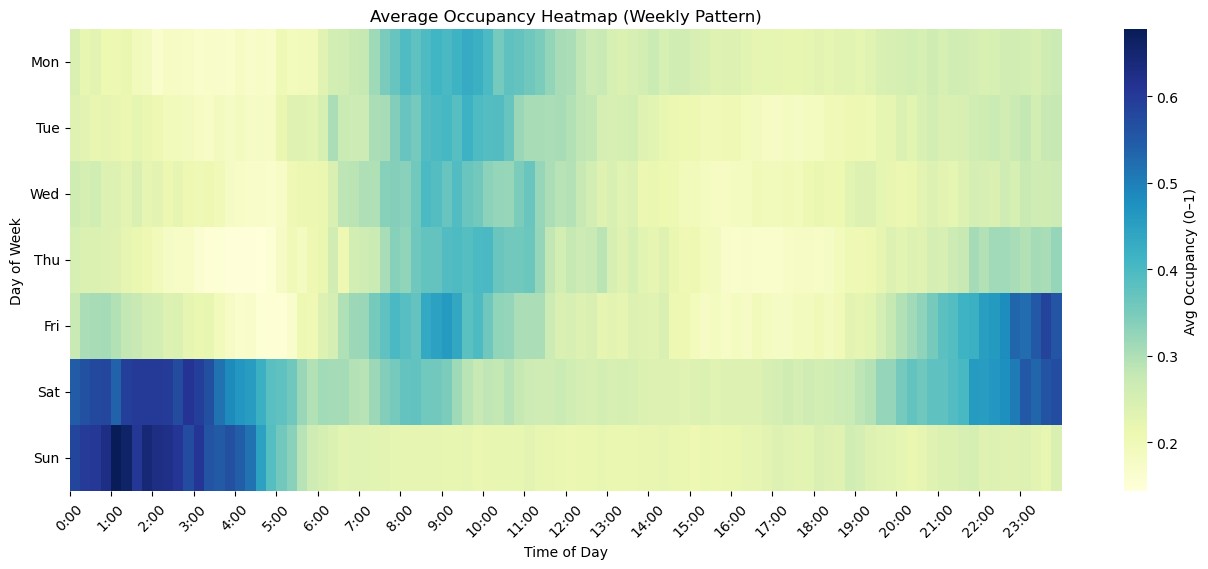

In [369]:
heatmap_data = data
heatmap_data['day_of_week'] = heatmap_data['date'].dt.dayofweek

heatmap_data = heatmap_data.groupby(['day_of_week','slot'])['status'].mean().unstack()
heatmap_data = heatmap_data.astype(float)  # force numeric

plt.figure(figsize=(16,6))
sns.heatmap(heatmap_data, cmap="YlGnBu", cbar_kws={'label':'Avg Occupancy (0–1)'})
plt.xlabel("Time of Day")
plt.ylabel("Day of Week")
plt.title("Average Occupancy Heatmap (Weekly Pattern)")
xticks = np.arange(0, 96, 4)
xlabels = [str(i) + ":00" for i in range(24)]
plt.xticks(xticks, xlabels, rotation=45)
plt.yticks(np.arange(0.5,7.5), labels=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], rotation=0)
plt.show()

Heatmaps of the sensor data in Neude in different months

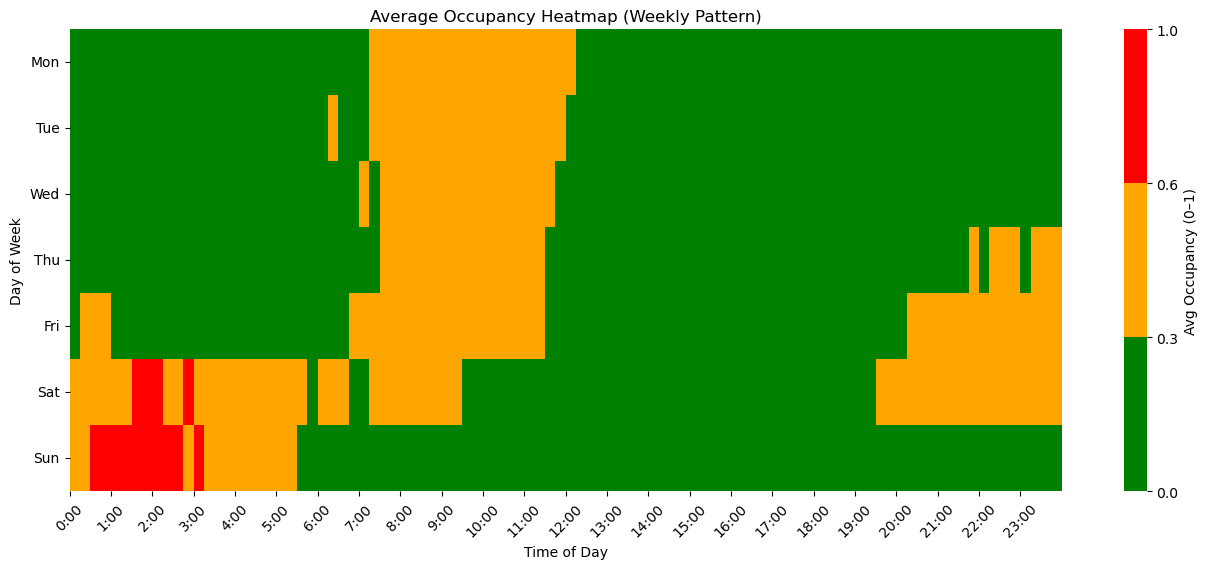

In [370]:
# Stel de drie kleuren en grenzen in
colors = ["green", "orange", "red"]
bounds = [0, 0.3, 0.6, 1]  # grenzen van de klassen
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(16,6))
sns.heatmap(
    heatmap_data,
    cmap=cmap,
    norm=norm,
    cbar_kws={'label': 'Avg Occupancy (0–1)'}
)

plt.xlabel("Time of Day")
plt.ylabel("Day of Week")
plt.title("Average Occupancy Heatmap (Weekly Pattern)")

xticks = np.arange(0, 96, 4)
xlabels = [f"{i}:00" for i in range(24)]
plt.xticks(xticks, xlabels, rotation=45)
plt.yticks(np.arange(0.5, 7.5), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], rotation=0)

plt.show()

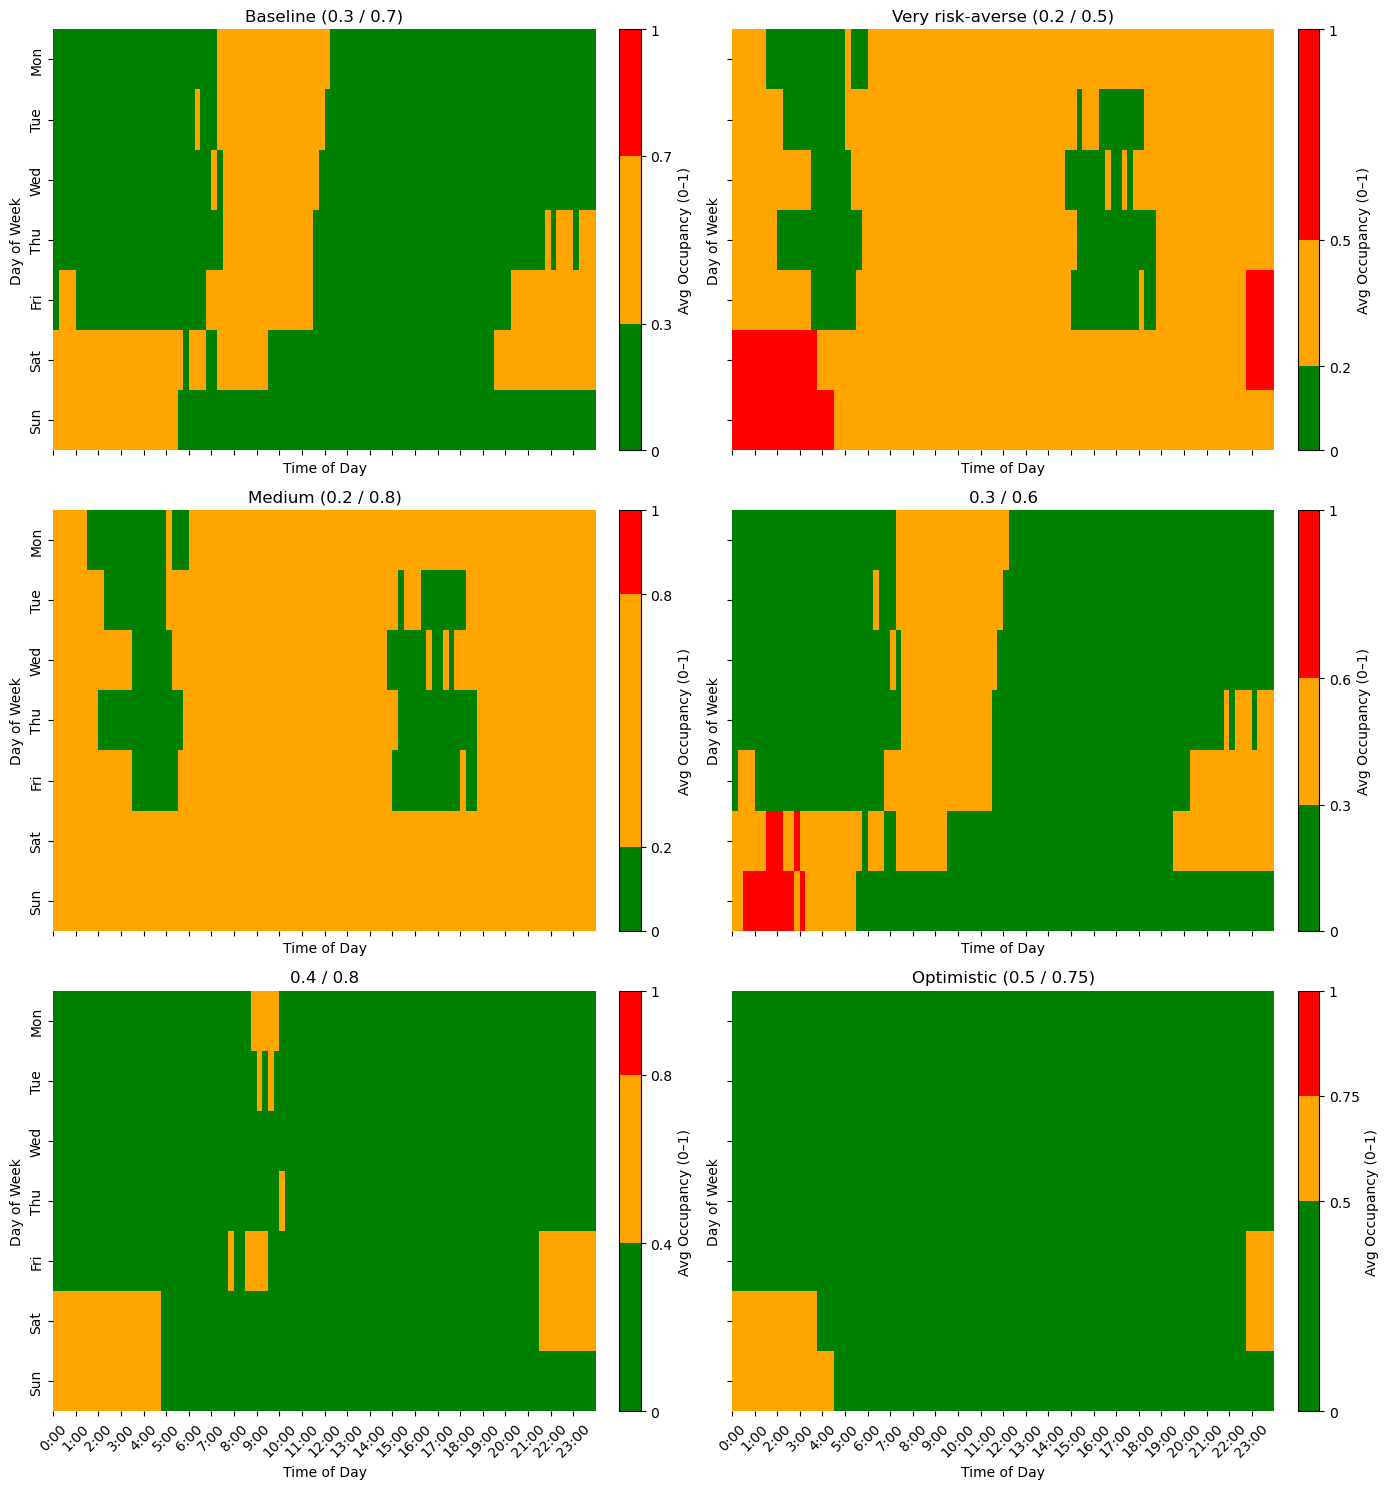

In [371]:

# voorbeeldkleuren
colors = ["green", "orange", "red"]

# Zorg dat je data numeriek is
data_plot = heatmap_data.astype(float)

cmap = ListedColormap(colors)

# 6 scenario's + namen
boundaries_list = [
    [0.0, 0.3, 0.7, 1.0],   # baseline
    [0.0, 0.2, 0.5, 1.0],   # very risk-averse
    [0.0, 0.2, 0.8, 1.0],   # medium
    [0.0, 0.3, 0.6, 1.0],   # iets strenger rond 0.6
    [0.0, 0.4, 0.8, 1.0],   # soepeler
    [0.0, 0.5, 0.75, 1.0],  # optimistic
]
scenario_names = [
    "Baseline (0.3 / 0.7)",
    "Very risk-averse (0.2 / 0.5)",
    "Medium (0.2 / 0.8)",
    "0.3 / 0.6",
    "0.4 / 0.8",
    "Optimistic (0.5 / 0.75)",
]

rows, cols = 3, 2
fig, axes = plt.subplots(rows, cols, figsize=(cols*7, rows*5), sharex=True, sharey=True, squeeze=False)

for ax, bounds, name in zip(axes.ravel(), boundaries_list, scenario_names):
    norm = BoundaryNorm(bounds, ncolors=cmap.N, clip=True)

    # Heatmap zonder auto-colorbar
    hm = sns.heatmap(
        data_plot,
        cmap=cmap,
        norm=norm,
        vmin=0, vmax=1,         # expliciet 0–1 bereik
        ax=ax,
        cbar=False,
        linewidths=0
    )

    # Discrete colorbar met segmenten die proportioneel de intervallen weergeven
    cbar = fig.colorbar(
        hm.collections[0],
        ax=ax,
        boundaries=bounds,
        ticks=bounds,                 # ticks precies op de grenzen (0, 0.3, 0.7, 1.0, etc.)
        spacing='proportional',       # <<< segment-lengtes volgen intervalgrootte
        fraction=0.046, pad=0.04
    )
    cbar.ax.set_yticklabels([f"{b:g}" for b in bounds])
    cbar.set_label("Avg Occupancy (0–1)")

    ax.set_title(name)
    ax.set_xlabel("Time of Day")
    ax.set_ylabel("Day of Week")
    ax.set_xticks(np.arange(0, 96, 4))
    ax.set_xticklabels([f"{i}:00" for i in range(24)], rotation=45)
    ax.set_yticks(np.arange(0.5, 7.5))
    ax.set_yticklabels(["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])

plt.tight_layout()
plt.show()

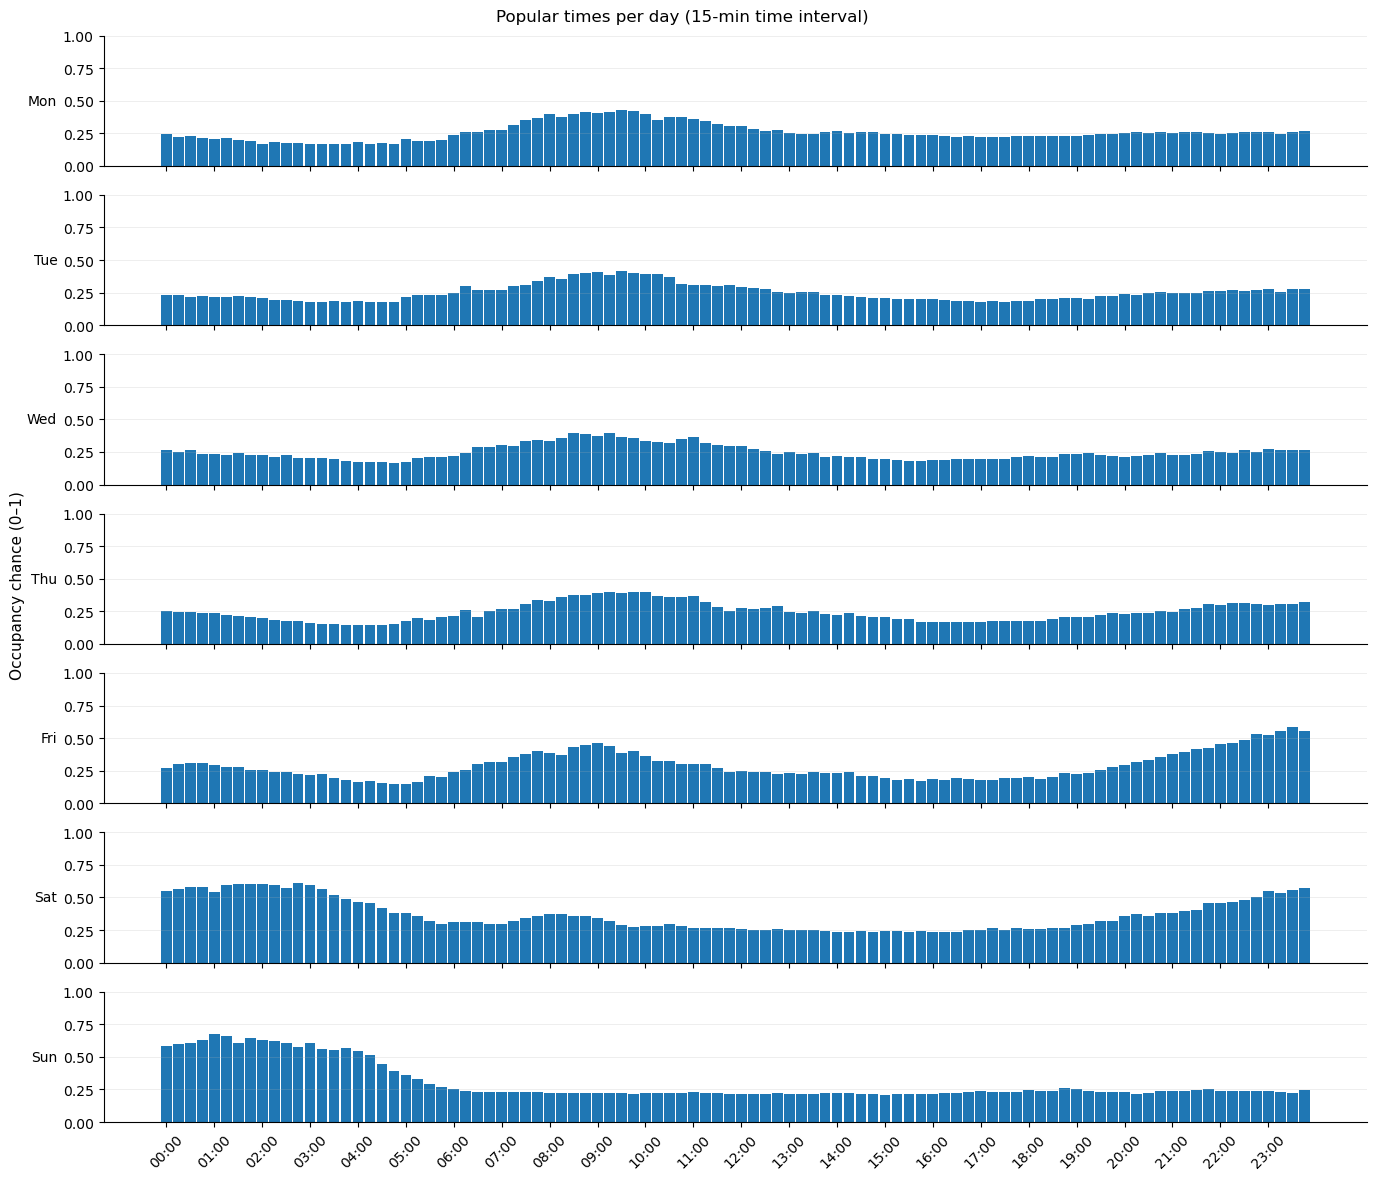

In [372]:
day_names = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]

fig, axes = plt.subplots(7, 1, figsize=(14, 12), sharex=True, sharey=True)

for d in range(7):
    ax = axes[d]
    y = heatmap_data.loc[d].values.astype(float)   # 96 waarden
    x = np.arange(96)

    ax.bar(x, y, width=0.9)                        # 96 balkjes (15 min)
    ax.set_ylim(0, 1)
    ax.set_ylabel(day_names[d], rotation=0, ha="right", va="center")
    ax.grid(axis="y", linewidth=0.5, alpha=0.3)

    # nette assen (zoals Google)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

# X-as: elke 4 slots = 1 uur
hour_ticks = np.arange(0, 96, 4)
hour_labels = [f"{h:02d}:00" for h in range(24)]
axes[-1].set_xticks(hour_ticks)
axes[-1].set_xticklabels(hour_labels, rotation=45)

fig.suptitle("Popular times per day (15-min time interval)")
fig.supylabel("Occupancy chance (0–1)", fontsize=11)
fig.tight_layout()
plt.show()

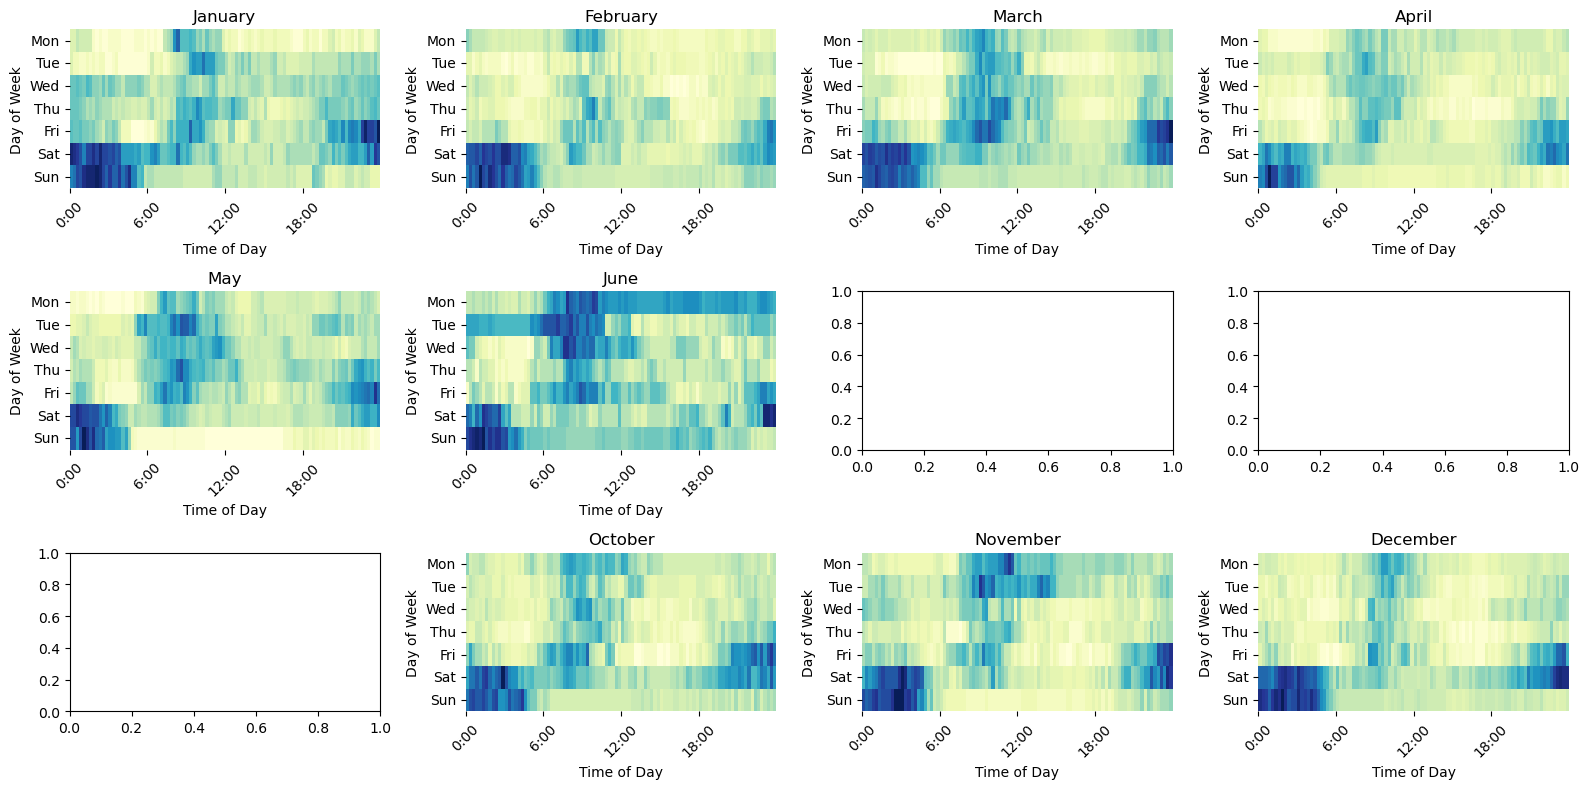

In [373]:
data['month'] = data['date'].dt.month  

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
axes = axes.flatten()

for month in range(1, 13):
    # Filter data voor de maand
    heatmap_data = data[data['month'] == month].copy()

    if heatmap_data.empty:
        continue  # sla over als er geen data is voor die maand

    # Zelfde verwerking als eerder
    heatmap_data = heatmap_data.sort_values('date')
    heatmap_data = heatmap_data.drop_duplicates(subset='date', keep='first')
    heatmap_data = (
        heatmap_data.set_index('date')
        .resample('15min')
        .ffill()
        .reset_index()
    )
    heatmap_data['day_of_week'] = heatmap_data['date'].dt.dayofweek
    heatmap_data['slot'] = heatmap_data['date'].dt.hour * 4 + heatmap_data['date'].dt.minute // 15

    # Groeperen en omvormen
    heatmap_data = (
        heatmap_data.groupby(['day_of_week', 'slot'])['status']
        .mean()
        .unstack()
        .astype(float)
    )
    

    ax = axes[month - 1]
    sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=False, ax=ax)
    ax.set_title(pd.to_datetime(f'2024-{month:02d}-01').strftime('%B'))
    ax.set_xlabel("Time of Day")
    ax.set_ylabel("Day of Week")

    xticks = np.arange(0, 96, 24)  # bijvoorbeeld elke 6 uur
    xlabels = [f"{i}:00" for i in range(0, 24, 6)]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, rotation=45)
    ax.set_yticks(np.arange(0.5, 7.5))
    ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"], rotation=0)

# Zorg voor goede spacing
plt.tight_layout()
plt.show()

## Feature engineering
Preparing the data to use for the XGBoost model. Making the rolling windows, lag features and 15-min slots.

In [374]:
# Rolling features
rolling_windows = {
    '1h': 4,
    '3h': 12, 
    '6h': 24, 
    '1d': 96, 
    '1w': 672
}

# Lag features
lags = [1, 2, 3, 4, 12, 24, 96, 672]

def load_data_for_zone(smartzone, dataset):
    # Copy original dataset
    data = dataset.copy()
    data = data[data['location name'] == smartzone]

    # Ensure integer status
    data['status'] = data['status'].astype(float)

    # Regularize timeseries
    data = data.sort_values('date')
    data = data.drop_duplicates(subset='date', keep='first')
    data = data.set_index('date').resample('15min').ffill().reset_index()

    # Time features
    data['day_of_week'] = data['date'].dt.dayofweek
    data['month'] = data['date'].dt.month
    data['day_of_month'] = data['date'].dt.day
    data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)
    data['slot'] = data['date'].dt.hour * 4 + data['date'].dt.minute // 15
    data['time_of_day'] = data['slot'] / 96
    data['dow_slot'] = data['day_of_week'].astype(str) + "_" + data['slot'].astype(str)

    for lag in lags:
        data[f'status_lag_{lag}'] = data['status'].shift(lag)

    for name, window in rolling_windows.items():
        data[f'status_roll_mean_{name}'] = data['status'].rolling(window).mean().shift(1)
        data[f'status_roll_max_{name}'] = data['status'].rolling(window).max().shift(1)
        data[f'status_roll_min_{name}'] = data['status'].rolling(window).min().shift(1)
        data[f'status_roll_sum_{name}'] = data['status'].rolling(window).sum().shift(1)

    # Drop NaNs after lag/rolling
    data = data.dropna().reset_index(drop=True)

    return data

data_with_features = load_data_for_zone(smartzone, dataset)


## Model training
Selecting which features to use and splitting the train and test set

## Model selection
Using XGBoost with regression

In [375]:
features = [
    'day_of_week','month','day_of_month','is_weekend','time_of_day','dow_slot',
    'status_lag_1','status_lag_2','status_lag_3','status_lag_4',
    'status_lag_12','status_lag_24','status_lag_96', 'status_lag_672',
    'status_roll_mean_1h','status_roll_max_1h','status_roll_min_1h','status_roll_sum_1h',
    'status_roll_mean_3h','status_roll_max_3h','status_roll_min_3h','status_roll_sum_3h',
    'status_roll_mean_6h','status_roll_max_6h','status_roll_min_6h','status_roll_sum_6h',
    'status_roll_mean_1d','status_roll_max_1d','status_roll_min_1d','status_roll_sum_1d',
    'status_roll_mean_1w','status_roll_max_1w','status_roll_min_1w','status_roll_sum_1w'
]

def get_model(data_set):
    model = xgb.XGBRegressor(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        enable_categorical=True,
        random_state=42,
    )
    
    X = data_set[features].copy()
    X['dow_slot'] = X['dow_slot'].astype('category')

    y = data_set['status'].astype(float)  # regression target (probability 0–1)

    # Train/test split (last 20% is test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    model.fit(X_train, y_train)

    # Predictions on test set
    y_pred = model.predict(X_test)
    y_pred = np.clip(y_pred,0,1)

    return model, X, X_train, X_test, y_pred, y_test


model, X, X_train, X_test, y_pred, y_test = get_model(data_with_features)


# Feature Selection Techniques
Some plots that show the importance of the features and checking if some features are not contributing enough.

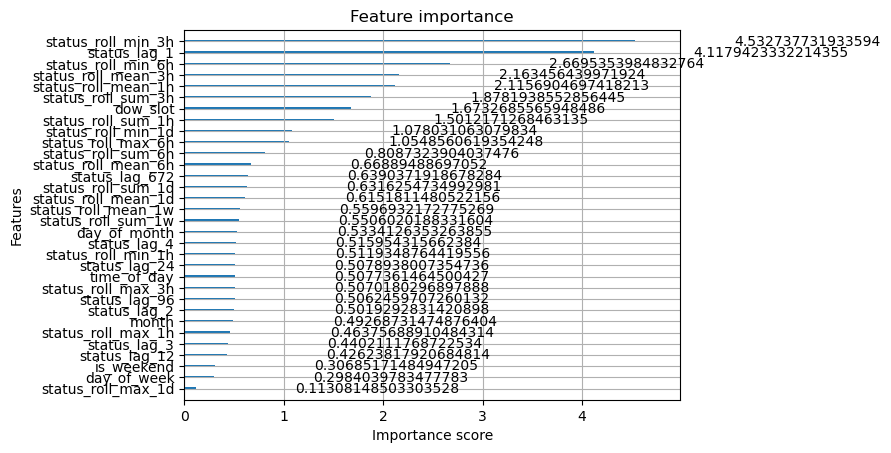

In [376]:
xgb.plot_importance(model, importance_type='gain', max_num_features=35)
plt.show()

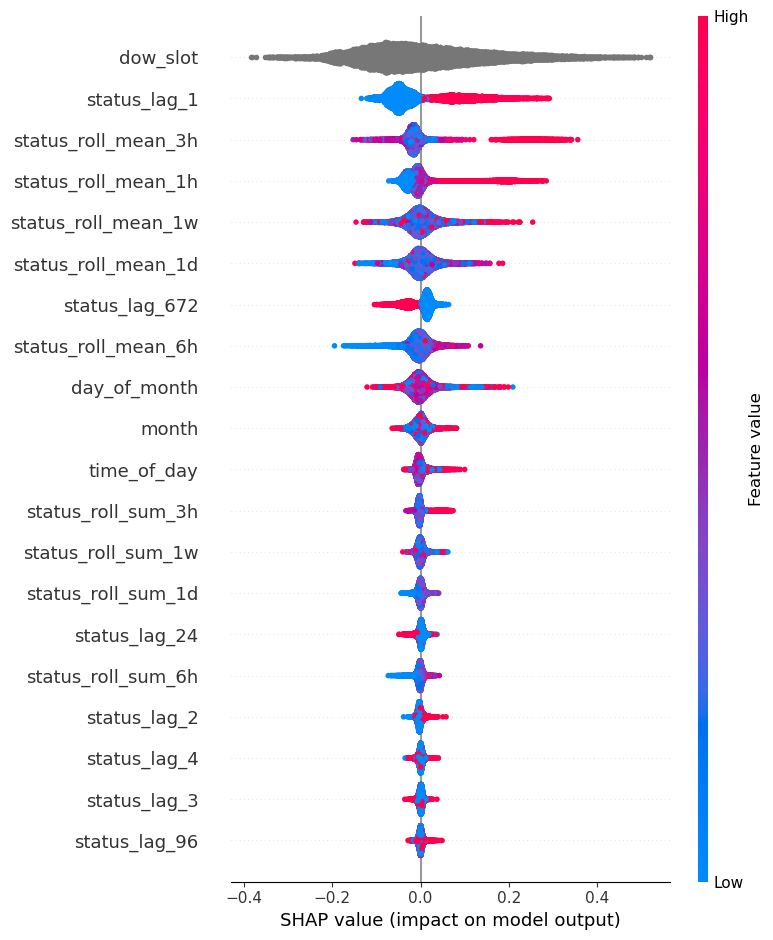

In [377]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

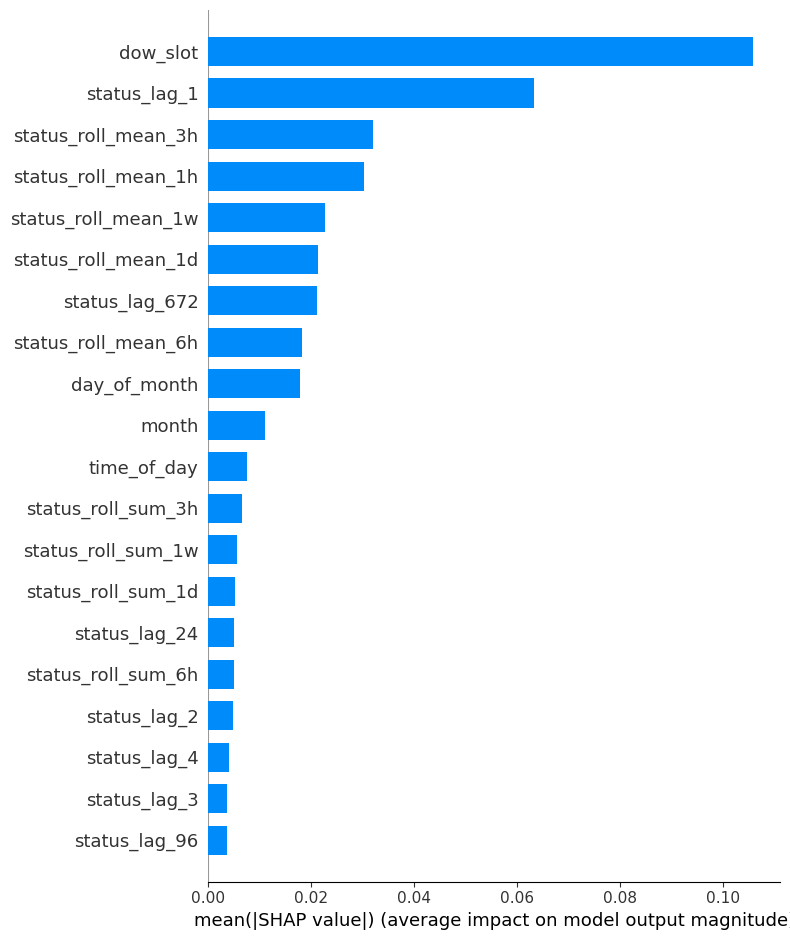

In [378]:
shap.summary_plot(shap_values, X_train, plot_type="bar")


## Model evaluation
evaluating the model using the logloss metric

In [379]:
# Evaluate
def evaluation(y_test, y_pred):
    roc_auc = roc_auc_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    return roc_auc, rmse, mae

roc_auc, rmse, mae = evaluation(y_test, y_pred)

print(f"Tests: ROC AUC: {roc_auc:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} ")

Tests: ROC AUC: 0.6301 | RMSE: 0.4720 | MAE: 0.3953 


## Results visualization
Heatmap of the test set data, showing the average occupancy of the spot in 15-min intervals in Neude.

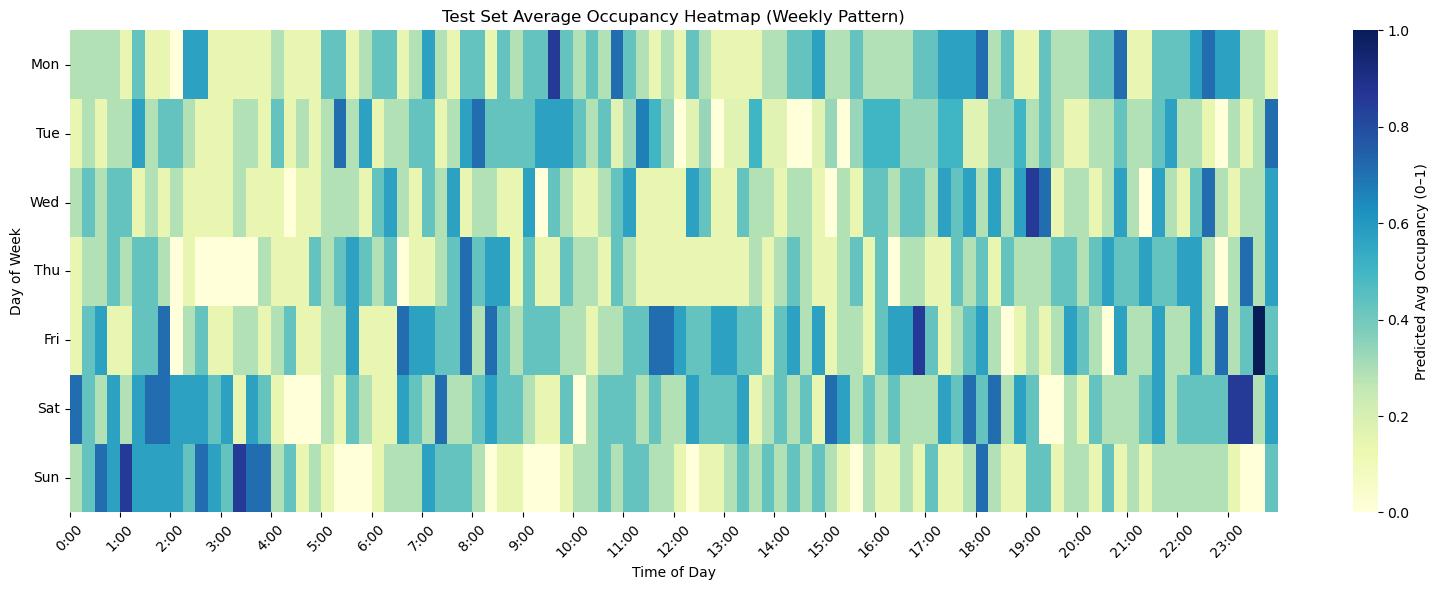

In [380]:
X_test["occupancy"] = y_test

X_test['slot'] = X_test['dow_slot'].astype(str).str.split("_").str[1].astype(int)

heatmap_pred = (
    X_test.groupby(["day_of_week", "slot"])["occupancy"]
    .mean()
    .unstack()
)

# Plot
plt.figure(figsize=(16,6))
sns.heatmap(heatmap_pred, cmap="YlGnBu", cbar_kws={'label': 'Predicted Avg Occupancy (0–1)'})
plt.xlabel("Time of Day")
plt.ylabel("Day of Week")
plt.title("Test Set Average Occupancy Heatmap (Weekly Pattern)")

xticks = np.arange(0, 96, 4)
xlabels = [f"{i}:00" for i in range(24)]
plt.xticks(xticks, xlabels, rotation=45)
plt.yticks(np.arange(0.5, 7.5), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], rotation=0)
plt.tight_layout()
plt.show()

Heatmap of the predicted data, showing the predicted occupancy of the spot in the 15-min slots in Neude.

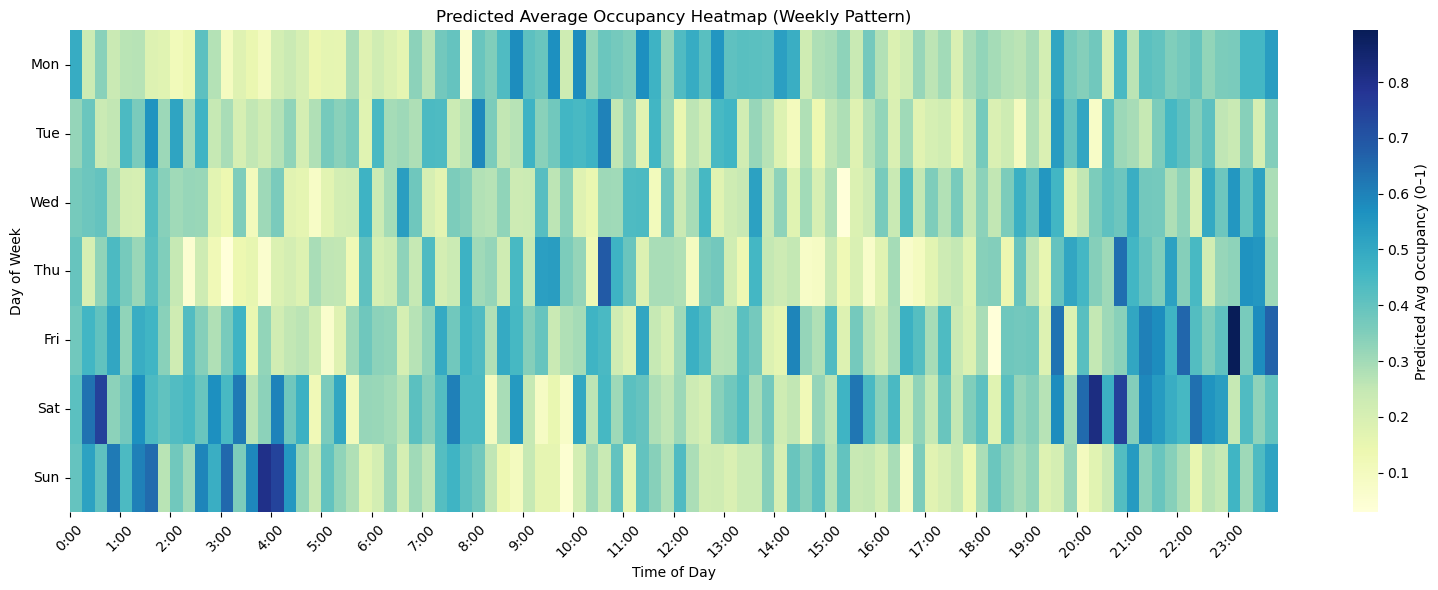

In [381]:

data_pred = X_test.copy()
data_pred["prediction"] = y_pred

data_pred['slot'] = data_pred['dow_slot'].astype(str).str.split("_").str[1].astype(int)

heatmap_pred = (
    data_pred.groupby(["day_of_week", "slot"])["prediction"]
    .mean()
    .unstack()
)

# Plot
plt.figure(figsize=(16,6))
sns.heatmap(heatmap_pred, cmap="YlGnBu", cbar_kws={'label': 'Predicted Avg Occupancy (0–1)'})
plt.xlabel("Time of Day")
plt.ylabel("Day of Week")
plt.title("Predicted Average Occupancy Heatmap (Weekly Pattern)")

xticks = np.arange(0, 96, 4)
xlabels = [f"{i}:00" for i in range(24)]
plt.xticks(xticks, xlabels, rotation=45)
plt.yticks(np.arange(0.5, 7.5), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], rotation=0)
plt.tight_layout()
plt.show()

Lineplot of the predicted occupancy against the true occupancy in the test set for the spot in Neude.

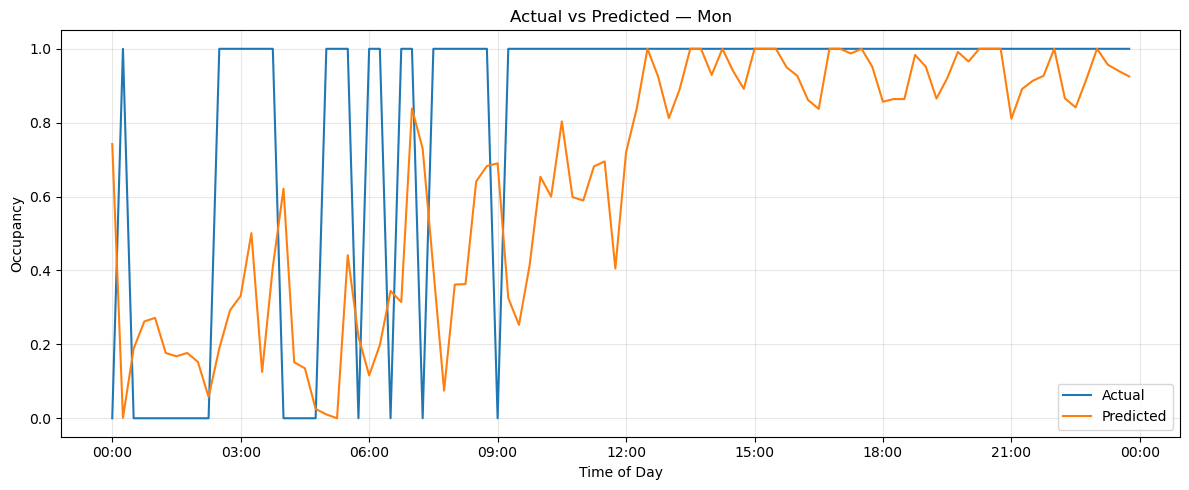

In [382]:
df = X_test.copy()
df["y_true"] = y_test
df["y_pred"] = y_pred

df[["day_of_week","slot"]] = (
    df["dow_slot"].astype(str).str.split("_", expand=True).astype(int)
)

dow = 0
dom = 16
m = 6

day_names = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
title_day = day_names[dow]

day_df = (df[(df["day_of_week"] == dow) & (df["day_of_month"] == dom) & (df["month"] == m)]
          .groupby("slot")[["y_true","y_pred"]]
          .mean()
          .reset_index()
          .sort_values("slot"))

time_base = pd.to_datetime("2000-01-01")  # arbitraire datum
day_df["time"] = time_base + pd.to_timedelta(day_df["slot"] * 15, unit="m")

plt.figure(figsize=(12,5))
plt.plot(day_df["time"], day_df["y_true"], label="Actual")
plt.plot(day_df["time"], day_df["y_pred"], label="Predicted")
plt.title(f"Actual vs Predicted — {title_day}")
plt.xlabel("Time of Day")
plt.ylabel("Occupancy")
plt.legend()
plt.grid(alpha=0.3)

# Mooie tijdlabels
ax = plt.gca()
ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))
plt.tight_layout()
plt.show()

## Forecasting for Dashboard
Here we made a forcasting of a week that we can later use in the dashboard. For now this is not complete or correct. 

In [383]:
def get_forecasting_df(X, model, data):
    dow_slot_cats = X['dow_slot'].cat.categories  

    max_lag = max(lags)
    hist = data.copy().reset_index(drop=True)
    hist_needed = hist.tail(max(672, max_lag) )   

    hist_status = hist_needed['status'].to_numpy()
    start_ts = hist_needed['date'].iloc[-1]

    H = 96 * 7  # 1 week in advance in 15-min slots
    pred_ts, pred_vals = [], []

    for k in range(0, H):
        ts   = start_ts + pd.Timedelta(minutes=15 * k)
        slot = ts.hour * 4 + ts.minute // 15
        dow  = ts.dayofweek

        feats = {
            'day_of_week': dow,
            'month': ts.month,
            'day_of_month': ts.day,
            'is_weekend': int(dow >= 5),
            'time_of_day': slot / 96,
            'dow_slot': f"{dow}_{slot}",
        }

        for L in lags:
            idx = -(L - k) - 1
            if idx < -len(hist_status):
                feats[f'status_lag_{L}'] = np.nan
            else:
                feats[f'status_lag_{L}'] = float(hist_status[idx])

        for name in rolling_windows.keys():
            feats[f'status_roll_mean_{name}'] = np.nan
            feats[f'status_roll_max_{name}']  = np.nan
            feats[f'status_roll_min_{name}']  = np.nan
            feats[f'status_roll_sum_{name}']  = np.nan

        Xp = pd.DataFrame([feats])[features]
        Xp['dow_slot'] = pd.Categorical(Xp['dow_slot'], categories=dow_slot_cats)

        p = model.predict(Xp)[0]

        pred_ts.append(ts)
        pred_vals.append(np.clip(p, 0, 1))

    forecast_df = pd.DataFrame({'date': pred_ts, 'status_pred': pred_vals})
    return forecast_df

forecast_df = get_forecasting_df(X, model, data_with_features)

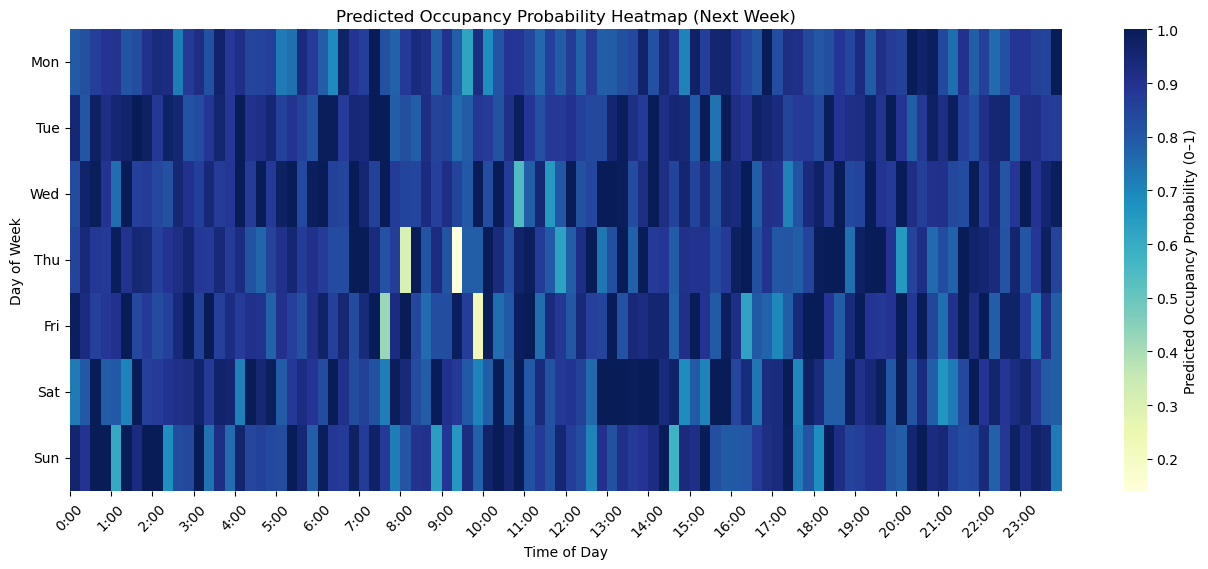

In [384]:
def get_forecast_heatmap(forecast_df):
    forecast_df['day_of_week'] = forecast_df['date'].dt.dayofweek
    forecast_df['slot'] = forecast_df['date'].dt.hour * 4 + forecast_df['date'].dt.minute // 15

    heatmap_matrix = forecast_df.groupby(['day_of_week','slot'])['status_pred'].mean().unstack()

    plt.figure(figsize=(16,6))
    sns.heatmap(heatmap_matrix, cmap="YlGnBu", cbar_kws={'label':'Predicted Occupancy Probability (0–1)'})
    plt.xlabel("Time of Day")
    plt.ylabel("Day of Week")
    plt.title("Predicted Occupancy Probability Heatmap (Next Week)")
    xticks = np.arange(0, 96, 4)
    xlabels = [str(i)+":00" for i in range(24)]
    plt.xticks(xticks, xlabels, rotation=45)
    plt.yticks(np.arange(0.5,7.5), labels=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], rotation=0)
    plt.show()

get_forecast_heatmap(forecast_df)

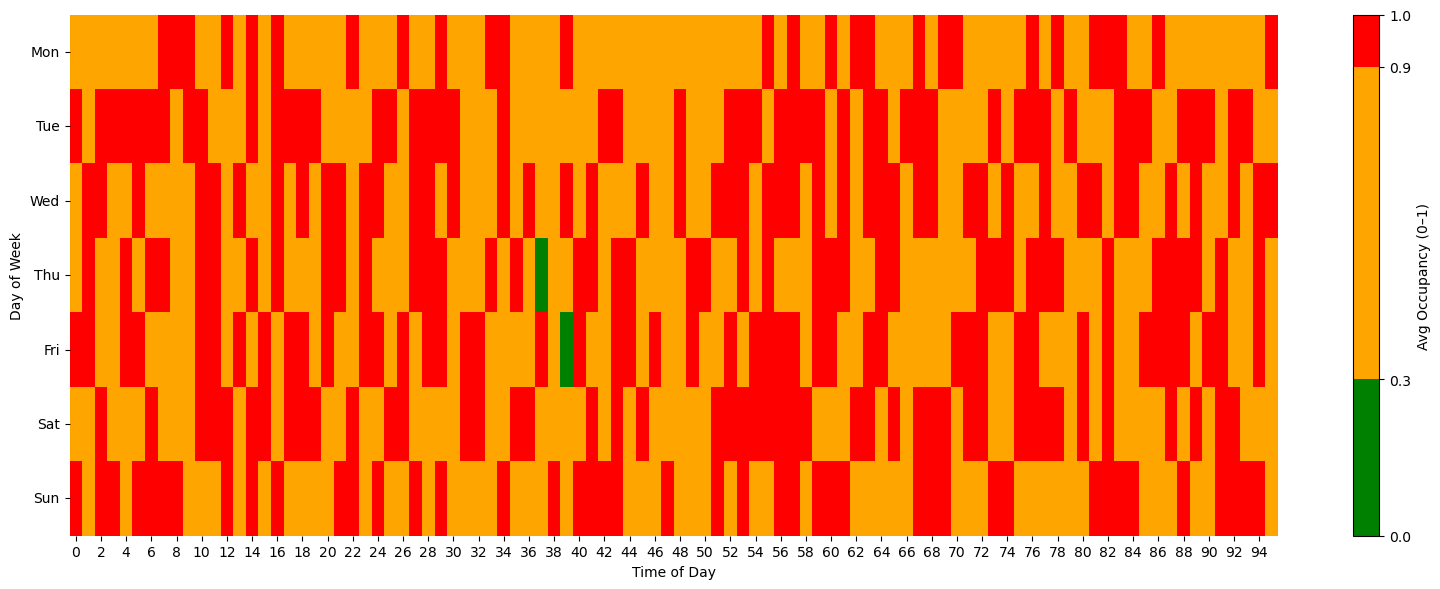

In [385]:
# Stel de drie kleuren en grenzen in
colors = ["green", "orange", "red"]
bounds = [0, 0.3, 0.9, 1]  # grenzen van de klassen
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, cmap.N)

forecast_df['day_of_week'] = forecast_df['date'].dt.dayofweek
forecast_df['slot'] = forecast_df['date'].dt.hour * 4 + forecast_df['date'].dt.minute // 15

heatmap_matrix = forecast_df.groupby(['day_of_week','slot'])['status_pred'].mean().unstack()

fig, ax = plt.subplots(figsize=(16,6))
hm = sns.heatmap(
    heatmap_matrix,
    cmap=cmap,
    norm=norm,
    vmin = 0, vmax = 1,
    ax = ax,
    cbar = False
)

cbar = fig.colorbar(
    hm.collections[0],
    ax=ax,
    boundaries=bounds,
    ticks=bounds,                # ticks op 0, 0.3, 0.7, 1.0
    spacing='proportional'       
)
cbar.set_label("Avg Occupancy (0–1)")

# (optioneel) mooiere ticklabels
cbar.ax.set_yticklabels([f"{b:.1f}" for b in bounds])
ax.set_xlabel("Time of Day")
ax.set_ylabel("Day of Week")
plt.yticks(np.arange(0.5,7.5), labels=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], rotation=0)
plt.tight_layout()
plt.show()

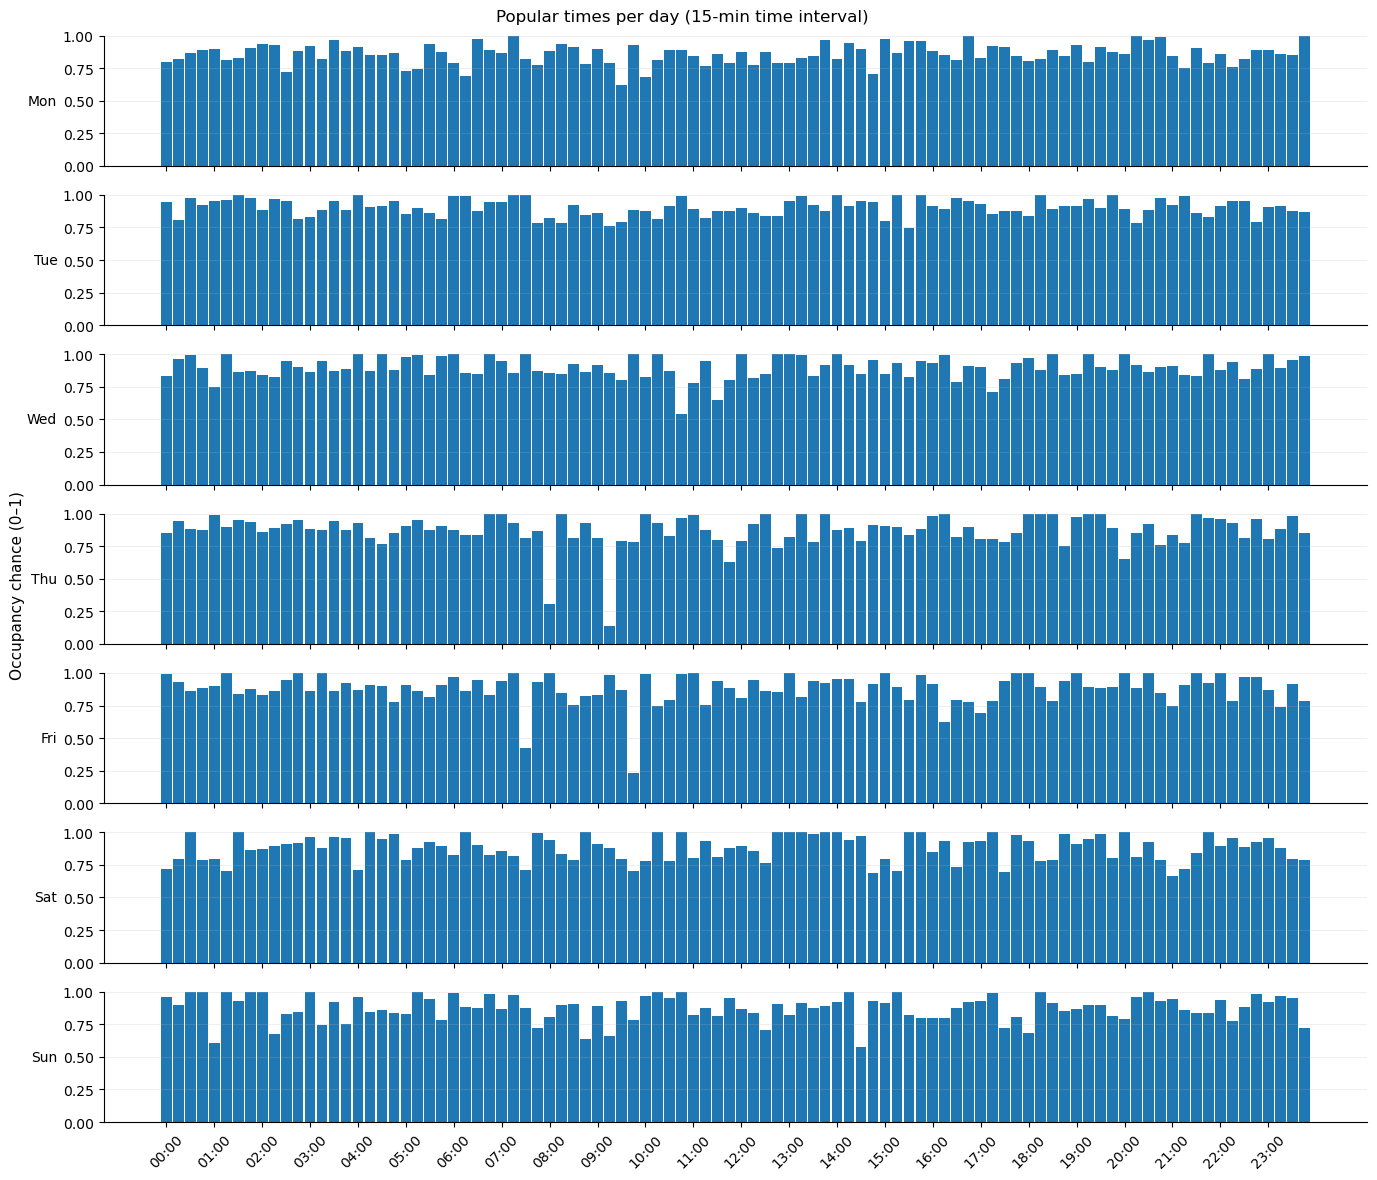

In [386]:
day_names = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]

fig, axes = plt.subplots(7, 1, figsize=(14, 12), sharex=True, sharey=True)

for d in range(7):
    ax = axes[d]
    y = heatmap_matrix.loc[d].values.astype(float)   # 96 waarden
    x = np.arange(96)

    ax.bar(x, y, width=0.9)                        # 96 balkjes (15 min)
    ax.set_ylim(0, 1)
    ax.set_ylabel(day_names[d], rotation=0, ha="right", va="center")
    ax.grid(axis="y", linewidth=0.5, alpha=0.3)

    # nette assen (zoals Google)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

# X-as: elke 4 slots = 1 uur
hour_ticks = np.arange(0, 96, 4)
hour_labels = [f"{h:02d}:00" for h in range(24)]
axes[-1].set_xticks(hour_ticks)
axes[-1].set_xticklabels(hour_labels, rotation=45)

fig.suptitle("Popular times per day (15-min time interval)")
fig.supylabel("Occupancy chance (0–1)", fontsize=11)
fig.tight_layout()
plt.show()

In [387]:
smartzone_dropdown = widgets.Dropdown(
    options=['Neude', 'Lange Viestraat', 'Stadhuisplein', 'Domplein', "'t Wed", 'Beurskwartier'],
    description='Smartzone:',
)

output = widgets.Output()

def on_zone_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        with output:
            clear_output()
            zone_widget = change['new']
            data_widget = load_data_for_zone(zone_widget, dataset)
            model_widget, Xt, _, _, _, _ = get_model(data_widget)
            preds = get_forecasting_df(Xt, model_widget, data_widget)
            get_forecast_heatmap(preds)

smartzone_dropdown.observe(on_zone_change)
display(smartzone_dropdown, output)

Dropdown(description='Smartzone:', options=('Neude', 'Lange Viestraat', 'Stadhuisplein', 'Domplein', "'t Wed",…

Output()